In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Seminar")

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertModel, get_scheduler

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

## Data ##

In [ ]:
train_df = pd.read_csv('Data/tweet/train_stockemo.csv')
train_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100001,2020-01-01,AMZN,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [...
1,100002,2020-01-01,TSLA,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's t...,Tesla Daddy's drinkin' eArly tonight! Here's t...
2,100003,2020-01-01,AAPL,confusion,bullish,$AAPL We’ll been riding since last December fr...,Apple We’ll been riding since last December fr...
3,100004,2020-01-01,TSLA,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine gla..."
4,100005,2020-01-01,TSLA,excitement,bullish,"$TSLA haha just a collection of greats...""Mars...","Tesla haha just a collection of greats...""Mars..."
...,...,...,...,...,...,...,...
7995,109536,2020-08-06,AAPL,surprise,bullish,BREAKING NEWS: $AAPL beats Elon Musk and Richa...,BREAKING NEWS: Apple beats Elon Musk and Richa...
7996,109541,2020-08-10,AAPL,belief,bullish,$AAPL why be a 2T giant and not dabble a littl...,Apple why be a 2T giant and not dabble a littl...
7997,109561,2020-08-18,AMZN,ambiguous,bullish,"$AMZN - 3,500 jobs = $3,500 ??? 😁","Amazon - 3,500 jobs = $3,500 ??? [beaming fac..."
7998,109795,2020-10-01,TSLA,surprise,bullish,$TSLA $500c 10/2 at 36k volume 👀👀,Tesla $500c 10/2 at 36k volume [eyes]


In [ ]:
test_df = pd.read_csv('Data/tweet/test_stockemo.csv')
test_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100067,2020-01-08,AAPL,confusion,bearish,$AAPL with all time highs again the market see...,Apple with all time highs again the market see...
1,100115,2020-01-10,BA,anxiety,bullish,$BA about to explode 🚨\nKeep shorting please,Boeing about to explode [police car light] \n...
2,100175,2020-01-15,SBUX,confusion,bearish,"$SBUX TPO alot of volume at 91.74, thats after...","Starbucks TPO alot of volume at 91.74, thats a..."
3,100234,2020-01-18,TSLA,confusion,bearish,$TSLA down 6$ afterhours right now 🤔,Tesla down 6$ afterhours right now [thinking ...
4,100268,2020-01-22,BA,confusion,bearish,$BA can someone tell me why they haven’t downg...,Boeing can someone tell me why they haven’t do...
...,...,...,...,...,...,...,...
995,109996,2020-12-31,ABNB,optimism,bearish,"$ABNB “sugar daddy puts.” Don’t mind me, I’m j...","Airbnb “sugar daddy puts.” Don’t mind me, I’m ..."
996,109997,2020-12-31,TSLA,disgust,bullish,$TSLA \nGood news... now bears can get help wh...,Tesla \nGood news... now bears can get help wh...
997,109998,2020-12-31,BABA,confusion,bullish,$BABA Who else is glad they sold in 240s yeste...,Alibaba Who else is glad they sold in 240s yes...
998,109999,2020-12-31,CCL,amusement,bullish,$CCL $23 calls for .79 you know what to do 🥳,Carnival $23 calls for .79 you know what to do...


In [ ]:
val_df = pd.read_csv('Data/tweet/val_stockemo.csv')
val_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100595,2020-02-06,TSLA,anger,bearish,$TSLA did jim Cramer just pull another bear St...,Tesla did jim Cramer just pull another bear St...
1,100693,2020-02-11,FB,anger,bearish,$FB uh oh FTC turning up the heat 💩,Facebook uh oh FTC turning up the heat [pile ...
2,101203,2020-03-04,AAPL,anger,bullish,$AAPL why are they holding it here! WTF! ✌🏽 GL...,Apple why are they holding it here! WTF! [vic...
3,101223,2020-03-05,MSFT,belief,bullish,$MSFT 🍀🍀Target $200.00 long term ☀️☀️☀️☀️☀️,Microsoft [four leaf clover] Target $200.00 ...
4,101349,2020-03-11,AMZN,anger,bullish,$AMZN another RED day... thus is just plain ou...,Amazon another RED day... thus is just plain o...
...,...,...,...,...,...,...,...
995,108995,2020-12-31,TSLA,disgust,bullish,$TSLA What’s twice as good as $420? —————> $840 😎,Tesla What’s twice as good as $420? —————> $84...
996,108996,2020-12-31,FB,anxiety,bearish,$FB We’ll that’s some options fuckery by insti...,Facebook We’ll that’s some options fuckery by ...
997,108997,2020-12-31,TSLA,optimism,bullish,$TSLA the daily looks like a big ✅ check mark!...,Tesla the daily looks like a big [check mark ...
998,108998,2020-12-31,BA,optimism,bullish,"$BA this will pump when you least expect it, r...",Boeing this will pump when you least expect it...


In [ ]:
tweets_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

Dữ liệu giá cổ phiếu

In [ ]:
price_data = {}
import os
for fname in os.listdir("Data/price"):
    if fname.endswith(".csv"):
        ticker = fname.replace(".csv", "")
        df = pd.read_csv(f"Data/price/{fname}")
        df['date'] = pd.to_datetime(df['Date'])
        price_data[ticker] = df


In [ ]:
price_data

{'UPS':            Date        Open        High         Low       Close   Adj Close  \
 0    2019-12-31  116.040001  117.089996  115.570000  117.059998  103.246529   
 1    2020-01-02  117.680000  117.970001  115.230003  116.790001  103.008392   
 2    2020-01-03  114.970001  116.860001  114.839996  116.720001  102.946663   
 3    2020-01-06  115.449997  116.230003  114.370003  116.199997  102.488014   
 4    2020-01-07  115.860001  116.440002  115.070000  116.000000  102.311600   
 ..          ...         ...         ...         ...         ...         ...   
 249  2020-12-24  173.009995  173.350006  171.470001  172.190002  156.922928   
 250  2020-12-28  172.600006  173.199997  170.899994  171.360001  156.166504   
 251  2020-12-29  171.750000  172.009995  168.399994  169.029999  154.043121   
 252  2020-12-30  169.820007  169.820007  166.149994  166.229996  151.491379   
 253  2020-12-31  166.789993  168.479996  165.440002  168.399994  153.468964   
 
       Volume       date  
 0  

Emotion Embedding bằng Glove

In [ ]:
emotion_list = ['ambiguous', 'amusement', 'anger', 'anxiety', 'belief',
                'confusion', 'depression', 'disgust', 'excitement',
                'optimism', 'panic', 'surprise']
emo_map = {i: emotion_list[i] for i in range(len(emotion_list))}

In [ ]:
def load_glove(path, dim=100):
    glove = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vec = list(map(float, parts[1:]))
            glove[word] = vec
    return glove

In [ ]:
def emo_to_vec(label):
    word = emo_map.get(label, "neutral")
    return glove.get(word, [0]*100)

In [ ]:
glove = load_glove("glove.6B.100d.txt")
tweets_df['emotion_vec'] = tweets_df['emo_label'].apply(emo_to_vec)

BERT Embedding cho tweet

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

@torch.no_grad()
def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=64, padding=True)
    outputs = model(**inputs)
    cls = outputs.last_hidden_state[0][0]  # [CLS]
    return cls.numpy()

from tqdm import tqdm
tqdm.pandas()
tweets_df['text_vec'] = tweets_df['processed'].progress_apply(bert_encode)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  0%|          | 9/10000 [00:02<41:57,  3.97it/s]


KeyboardInterrupt: 

In [ ]:
# # Sau khi đã có tweets_df['text_vec']
# tweets_df.to_pickle("tweets_with_vec.pkl")
tweets_df = pd.read_pickle("tweets_with_vec.pkl")

In [ ]:
tweets_df.head()
tweets_df.shape

(10000, 9)

Chuẩn hóa price


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Hàm chuẩn hóa price cho từng ticker trong price_dict
def normalize_price(price_dict):
    normalized_price_dict = {}
    scaler_dict = {}  # Lưu scaler để sử dụng sau này (nếu cần đảo ngược chuẩn hóa)

    for ticker in price_dict:
        df_price = price_dict[ticker]

        # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
        df_price = df_price.copy()

        # Chuẩn hóa cột 'Close'
        scaler = MinMaxScaler()
        df_price['Close'] = scaler.fit_transform(df_price[['Close']])

        # Lưu scaler để sử dụng sau (nếu cần)
        scaler_dict[ticker] = scaler

        # Cập nhật price_dict đã chuẩn hóa
        normalized_price_dict[ticker] = df_price

    return normalized_price_dict, scaler_dict

# Chuẩn hóa price_data trước khi merge
normalized_price_dict, scaler_dict = normalize_price(price_data)

Gộp tweet với dữ liệu giá

In [ ]:
def merge_with_price(tweet_df, price_dict):
  full = []
  for ticker in tweet_df['ticker'].unique():
    if ticker not in price_dict:
      continue
    df_tweet = tweet_df[tweet_df['ticker'] == ticker]
    df_price = price_dict[ticker]
    merged = pd.merge(df_tweet, df_price[['date', 'Close']], on='date', how='inner')
    merged['price'] = merged['Close']
    full.append(merged)
  return pd.concat(full, ignore_index=True)

full_df = merge_with_price(tweets_df, normalized_price_dict)

In [ ]:
# test full_df

print(full_df.head())
# print(full_df.info())
# print(full_df.describe())
# full_df.shape


       id       date ticker   emo_label senti_label  \
0  100022 2020-01-03   AMZN   amusement     bullish   
1  100030 2020-01-06   AMZN  depression     bullish   
2  100053 2020-01-07   AMZN    optimism     bullish   
3  100096 2020-01-09   AMZN      belief     bearish   
4  100152 2020-01-14   AMZN    optimism     bullish   

                                            original  \
0  $AMZN who ever shorted today will be deported ...   
1  $AMZN I hope we can come close to touching 200...   
2  $AMZN CONGRATS TO ALL THE LONG - there were so...   
3            $AMZN Now it’s moving with the market 😂   
4  $AMZN dec. 24th, 31st, and Jan 7th were all ga...   

                                           processed  \
0  Amazon who ever shorted today will be deported...   
1  Amazon I hope we can come close to touching 20...   
2  Amazon CONGRATS TO ALL THE LONG - there were s...   
3  Amazon Now it’s moving with the market  [face ...   
4  Amazon dec. 24th, 31st, and Jan 7th were all g...

Tạo sliding window dataset

In [ ]:
def create_sliding_window_dataset(df, window_size=5, train_split=0.67):
    df = df.sort_values(by=['ticker', 'date']).reset_index(drop=True)

    text_dim = len(df['text_vec'].iloc[0])
    emotion_dim = len(df['emotion_vec'].iloc[0])
    df['text_vec'] = df['text_vec'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(text_dim))
    df['emotion_vec'] = df['emotion_vec'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(emotion_dim))

    data = []
    for ticker in df['ticker'].unique():
        df_ticker = df[df['ticker'] == ticker].reset_index(drop=True)

        for i in range(window_size, len(df_ticker)):
            window = df_ticker.iloc[i-window_size:i]

            if len(window) != window_size:
                continue

            sample = {
                'ticker': ticker,
                'text_seq': np.stack(window['text_vec'].values),
                'emo_seq': np.stack(window['emotion_vec'].values),
                'price_seq': window['price'].values.reshape(-1, 1),
                'target': df_ticker.iloc[i]['price']
            }
            data.append(sample)

    train_size = int(train_split * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]

    return train_data, test_data

In [ ]:
# train_df = full_df[full_df['date'] <= '2020-09-03'].copy()
# test_df = full_df[full_df['date'] >= '2020-09-04'].copy()

In [ ]:
for ticker in full_df['ticker'].unique():
    df_ticker = full_df[full_df['ticker'] == ticker]
    print(f"Ticker {ticker}: {len(df_ticker)} rows")

Ticker AMZN: 397 rows
Ticker TSLA: 4208 rows
Ticker AAPL: 1603 rows
Ticker HD: 39 rows
Ticker NVDA: 116 rows
Ticker GOOGL: 17 rows
Ticker NFLX: 190 rows
Ticker FB: 198 rows
Ticker DIS: 418 rows
Ticker BA: 895 rows
Ticker WMT: 116 rows
Ticker TSM: 10 rows
Ticker BABA: 236 rows
Ticker V: 41 rows
Ticker SBUX: 44 rows
Ticker BAC: 64 rows
Ticker UNH: 7 rows
Ticker XOM: 44 rows
Ticker MSFT: 258 rows
Ticker GOOG: 18 rows
Ticker PFE: 180 rows
Ticker CVX: 3 rows
Ticker PYPL: 37 rows
Ticker MCD: 21 rows
Ticker JPM: 34 rows
Ticker NKE: 29 rows
Ticker BKNG: 13 rows
Ticker CCL: 258 rows
Ticker MA: 8 rows
Ticker JNJ: 22 rows
Ticker AMT: 2 rows
Ticker LOW: 14 rows
Ticker KO: 12 rows
Ticker UPS: 15 rows
Ticker PG: 3 rows
Ticker ABNB: 49 rows


In [ ]:
# Tạo dataset
window_size = 5
train_data, test_data = create_sliding_window_dataset(full_df, window_size=window_size)

In [ ]:
len(train_data)

6328

Tạo class Dataset

In [ ]:
class MultimodalTimeSeriesDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]


    # Chuyển sang Tensor
    price_seq = torch.tensor(sample['price_seq'], dtype=torch.float32)
    text_seq = torch.tensor(sample['text_seq'], dtype=torch.float32)
    emo_seq = torch.tensor(sample['emo_seq'], dtype=torch.float32)
    target = torch.tensor(sample['target'], dtype=torch.float32)

    return {
        'ticker': sample['ticker'],
        'price_seq': price_seq,
        'text_seq': text_seq,
        'emo_seq': emo_seq,
        'target': target
    }

Tạo dataloader

In [ ]:
MTS_traindataset = MultimodalTimeSeriesDataset(train_data)
MTS_testdataset = MultimodalTimeSeriesDataset(test_data)
sample = MTS_traindataset[0]
print(sample['price_seq'].shape)
print(sample['text_seq'].shape)
print(sample['emo_seq'].shape)
print(sample['target'])


torch.Size([5, 1])
torch.Size([5, 768])
torch.Size([5, 100])
tensor(0.2357)


In [ ]:
train_loader = DataLoader(MTS_traindataset, batch_size=32, shuffle=True)
test_loader = DataLoader(MTS_testdataset, batch_size=32, shuffle=False)

In [ ]:
# Kiểm tra một batch
for batch in train_loader:
    print("ticker:", batch['ticker'])  # List of tickers
    print("text_seq shape:", batch['text_seq'].shape)  # (batch_size, window_size, 768)
    print("emo_seq shape:", batch['emo_seq'].shape)    # (batch_size, window_size, 100)
    print("price_seq shape:", batch['price_seq'].shape)  # (batch_size, window_size, 1)
    print("target shape:", batch['target'].shape)      # (batch_size,)
    break

ticker: ['AMZN', 'TSLA', 'JPM', 'DIS', 'TSLA', 'AAPL', 'CCL', 'FB', 'TSLA', 'BABA', 'AAPL', 'AAPL', 'PFE', 'BAC', 'TSLA', 'BA', 'TSLA', 'TSLA', 'TSLA', 'DIS', 'TSLA', 'NFLX', 'DIS', 'TSLA', 'NFLX', 'AAPL', 'FB', 'PYPL', 'TSLA', 'TSLA', 'TSLA', 'DIS']
text_seq shape: torch.Size([32, 5, 768])
emo_seq shape: torch.Size([32, 5, 100])
price_seq shape: torch.Size([32, 5, 1])
target shape: torch.Size([32])


Xây dựng mô hình TemporalAttentionLSTM

In [ ]:
for batch in train_loader:
    print("price_seq:", batch['price_seq'].shape)   # (B, seq_len, 1)
    print("text_seq:", batch['text_seq'].shape)     # (B, seq_len, 768)
    print("emo_seq:", batch['emo_seq'].shape)       # (B, seq_len, 100)
    print("target:", batch['target'].shape)         # (B,)
    break


price_seq: torch.Size([32, 5, 1])
text_seq: torch.Size([32, 5, 768])
emo_seq: torch.Size([32, 5, 100])
target: torch.Size([32])


In [ ]:
class ContextEncoder(nn.Module):
    def __init__(self, sentence_dim=768, emotion_dim=100, output_dim=128):
        super(ContextEncoder, self).__init__()
        self.sentence_projector = nn.Linear(sentence_dim, output_dim)
        self.emotion_projector = nn.Linear(emotion_dim, output_dim)
        self.combine = nn.Linear(output_dim * 2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, sentence, emotion):
        sentence_projected = self.relu(self.sentence_projector(sentence))
        emotion_projected = self.relu(self.emotion_projector(emotion))
        combined = torch.cat((sentence_projected, emotion_projected), dim=-1)
        context = self.relu(self.combine(combined))
        return context

In [ ]:
class PriceEncoder(nn.Module):
    def __init__(self, price_dim=1, output_dim=128):
        super(PriceEncoder, self).__init__()
        self.price_projector = nn.Linear(price_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, price):
        price_projected = self.relu(self.price_projector(price))
        return price_projected

In [ ]:
class Encoder(nn.Module):
    def __init__(self, sentence_dim=768, emotion_dim=100, price_dim=1, output_dim=128):
        super(Encoder, self).__init__()
        self.context_encoder = ContextEncoder(sentence_dim, emotion_dim, output_dim)
        self.price_encoder = PriceEncoder(price_dim, output_dim)
        self.combine = nn.Linear(output_dim * 2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, sentence, emotion, price):
        context = self.context_encoder(sentence, emotion)
        price_encoded = self.price_encoder(price)
        combined = torch.cat((context, price_encoded), dim=-1)
        h = self.relu(self.combine(combined))
        return h

In [ ]:
class TemporalAttention(nn.Module):
    def __init__(self, input_dim):
        super(TemporalAttention, self).__init__()
        self.W = nn.Parameter(torch.randn(input_dim, 1))
        self.b = nn.Parameter(torch.zeros(window_size, 1))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, h):
        e = torch.tanh(torch.matmul(h, self.W) + self.b)
        e = self.softmax(e)
        h_attention = h * e
        return h_attention

In [ ]:
class FinBERTMTS(nn.Module):
    def __init__(self,sentence_dim=768, emotion_dim=100, price_dim=1, encoder_output_dim=128, lstm_hidden_dim=50):
        super(FinBERTMTS, self).__init__()
        # Encoder
        self.encoder = Encoder(sentence_dim, emotion_dim, price_dim, encoder_output_dim)

        # Sequential Model (Temporal Attention + LSTM)
        self.attention = TemporalAttention(encoder_output_dim)
        self.lstm = nn.LSTM(encoder_output_dim, lstm_hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, sentence, emotion, price):
        # Encoder
        h = self.encoder(sentence, emotion, price)  # (batch_size, window_size, encoder_output_dim)

        # Sequential Model
        h_attention = self.attention(h)  # (batch_size, window_size, encoder_output_dim)
        lstm_output, _ = self.lstm(h_attention)  # (batch_size, window_size, lstm_hidden_dim)
        lstm_output = lstm_output[:, -1, :]  # Lấy output cuối cùng: (batch_size, lstm_hidden_dim)
        lstm_output = self.dropout(lstm_output)
        y_hat = self.fc(lstm_output)  # (batch_size, 1)
        return y_hat

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Khởi tạo model
model = FinBERTMTS().to(device)
# model = TemporalAttentionLSTM(price_input_size=1, text_input_size=768, emotion_input_size=100).to(device)

# Loss
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train

In [ ]:
def train(model, train_loader, epochs, device=device):
  model.train()
  train_losses=[]

  for epoch in range(epochs):
    epoch_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for batch in loop:
      price_seq = batch['price_seq'].to(device)
      text_seq = batch['text_seq'].to(device)
      emo_seq = batch['emo_seq'].to(device)
      target = batch['target'].to(device)

      optimizer.zero_grad()
      pred = model(text_seq, emo_seq,price_seq)
      loss = criterion(pred, target)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.6f}")
    train_losses.append(avg_loss)

  return train_losses


Evaluate

In [ ]:
def evaluate(model, test_loader, device=device):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for batch in test_loader:
      price_seq = batch['price_seq'].to(device)
      text_seq = batch['text_seq'].to(device)
      emo_seq = batch['emo_seq'].to(device)
      target = batch['target'].to(device)

      pred = model(text_seq, emo_seq,price_seq)
      loss = criterion(pred, target)
      total_loss += loss.item()

  avg_loss = total_loss / len(test_loader)
  print(f"Test Loss: {avg_loss:.6f}")
  model.train()

  return avg_loss

Train model

In [ ]:
train_losses = train(model, train_loader, epochs=100)

Epoch 1/100: 100%|██████████| 198/198 [00:01<00:00, 122.18it/s, loss=0.0818]


Epoch 1/100 - Train Loss: 0.093843


Epoch 2/100: 100%|██████████| 198/198 [00:01<00:00, 115.37it/s, loss=0.0635]


Epoch 2/100 - Train Loss: 0.089247


Epoch 3/100: 100%|██████████| 198/198 [00:01<00:00, 119.94it/s, loss=0.0888]


Epoch 3/100 - Train Loss: 0.089365


Epoch 4/100: 100%|██████████| 198/198 [00:01<00:00, 139.11it/s, loss=0.0844]


Epoch 4/100 - Train Loss: 0.089331


Epoch 5/100: 100%|██████████| 198/198 [00:01<00:00, 139.08it/s, loss=0.112]


Epoch 5/100 - Train Loss: 0.089325


Epoch 6/100: 100%|██████████| 198/198 [00:01<00:00, 138.14it/s, loss=0.0841]


Epoch 6/100 - Train Loss: 0.088753


Epoch 7/100: 100%|██████████| 198/198 [00:01<00:00, 138.13it/s, loss=0.0986]


Epoch 7/100 - Train Loss: 0.088575


Epoch 8/100: 100%|██████████| 198/198 [00:01<00:00, 137.45it/s, loss=0.092]


Epoch 8/100 - Train Loss: 0.088897


Epoch 9/100: 100%|██████████| 198/198 [00:01<00:00, 138.90it/s, loss=0.104]


Epoch 9/100 - Train Loss: 0.088600


Epoch 10/100: 100%|██████████| 198/198 [00:01<00:00, 125.89it/s, loss=0.1]


Epoch 10/100 - Train Loss: 0.088729


Epoch 11/100: 100%|██████████| 198/198 [00:01<00:00, 110.50it/s, loss=0.103]


Epoch 11/100 - Train Loss: 0.088542


Epoch 12/100: 100%|██████████| 198/198 [00:01<00:00, 119.53it/s, loss=0.0994]


Epoch 12/100 - Train Loss: 0.088591


Epoch 13/100: 100%|██████████| 198/198 [00:01<00:00, 138.54it/s, loss=0.103]


Epoch 13/100 - Train Loss: 0.088323


Epoch 14/100: 100%|██████████| 198/198 [00:01<00:00, 139.08it/s, loss=0.0769]


Epoch 14/100 - Train Loss: 0.088374


Epoch 15/100: 100%|██████████| 198/198 [00:01<00:00, 138.70it/s, loss=0.0894]


Epoch 15/100 - Train Loss: 0.088266


Epoch 16/100: 100%|██████████| 198/198 [00:01<00:00, 140.09it/s, loss=0.113]


Epoch 16/100 - Train Loss: 0.088288


Epoch 17/100: 100%|██████████| 198/198 [00:01<00:00, 140.34it/s, loss=0.113]


Epoch 17/100 - Train Loss: 0.088268


Epoch 18/100: 100%|██████████| 198/198 [00:01<00:00, 140.30it/s, loss=0.0736]


Epoch 18/100 - Train Loss: 0.088315


Epoch 19/100: 100%|██████████| 198/198 [00:01<00:00, 124.08it/s, loss=0.0899]


Epoch 19/100 - Train Loss: 0.088155


Epoch 20/100: 100%|██████████| 198/198 [00:02<00:00, 78.65it/s, loss=0.0766]


Epoch 20/100 - Train Loss: 0.088255


Epoch 21/100: 100%|██████████| 198/198 [00:01<00:00, 134.16it/s, loss=0.0943]


Epoch 21/100 - Train Loss: 0.088168


Epoch 22/100: 100%|██████████| 198/198 [00:01<00:00, 139.74it/s, loss=0.0926]


Epoch 22/100 - Train Loss: 0.088153


Epoch 23/100: 100%|██████████| 198/198 [00:01<00:00, 138.79it/s, loss=0.0736]


Epoch 23/100 - Train Loss: 0.088079


Epoch 24/100: 100%|██████████| 198/198 [00:01<00:00, 139.79it/s, loss=0.0859]


Epoch 24/100 - Train Loss: 0.088013


Epoch 25/100: 100%|██████████| 198/198 [00:01<00:00, 138.90it/s, loss=0.106]


Epoch 25/100 - Train Loss: 0.088103


Epoch 26/100: 100%|██████████| 198/198 [00:01<00:00, 140.28it/s, loss=0.0713]


Epoch 26/100 - Train Loss: 0.088217


Epoch 27/100: 100%|██████████| 198/198 [00:01<00:00, 136.86it/s, loss=0.0872]


Epoch 27/100 - Train Loss: 0.088030


Epoch 28/100: 100%|██████████| 198/198 [00:01<00:00, 112.09it/s, loss=0.0705]


Epoch 28/100 - Train Loss: 0.088113


Epoch 29/100: 100%|██████████| 198/198 [00:01<00:00, 108.21it/s, loss=0.0984]


Epoch 29/100 - Train Loss: 0.087939


Epoch 30/100: 100%|██████████| 198/198 [00:01<00:00, 132.89it/s, loss=0.101]


Epoch 30/100 - Train Loss: 0.088078


Epoch 31/100: 100%|██████████| 198/198 [00:01<00:00, 136.43it/s, loss=0.0788]


Epoch 31/100 - Train Loss: 0.088042


Epoch 32/100: 100%|██████████| 198/198 [00:01<00:00, 136.86it/s, loss=0.0856]


Epoch 32/100 - Train Loss: 0.088153


Epoch 33/100: 100%|██████████| 198/198 [00:01<00:00, 136.32it/s, loss=0.122]


Epoch 33/100 - Train Loss: 0.087871


Epoch 34/100: 100%|██████████| 198/198 [00:01<00:00, 139.18it/s, loss=0.0917]


Epoch 34/100 - Train Loss: 0.088047


Epoch 35/100: 100%|██████████| 198/198 [00:01<00:00, 139.67it/s, loss=0.122]


Epoch 35/100 - Train Loss: 0.088029


Epoch 36/100: 100%|██████████| 198/198 [00:01<00:00, 138.84it/s, loss=0.0992]


Epoch 36/100 - Train Loss: 0.087876


Epoch 37/100: 100%|██████████| 198/198 [00:01<00:00, 111.90it/s, loss=0.107]


Epoch 37/100 - Train Loss: 0.087828


Epoch 38/100: 100%|██████████| 198/198 [00:01<00:00, 108.26it/s, loss=0.0673]


Epoch 38/100 - Train Loss: 0.087884


Epoch 39/100: 100%|██████████| 198/198 [00:01<00:00, 128.91it/s, loss=0.0764]


Epoch 39/100 - Train Loss: 0.087947


Epoch 40/100: 100%|██████████| 198/198 [00:01<00:00, 136.86it/s, loss=0.103]


Epoch 40/100 - Train Loss: 0.087882


Epoch 41/100: 100%|██████████| 198/198 [00:01<00:00, 137.64it/s, loss=0.0671]


Epoch 41/100 - Train Loss: 0.087787


Epoch 42/100: 100%|██████████| 198/198 [00:01<00:00, 137.59it/s, loss=0.118]


Epoch 42/100 - Train Loss: 0.087954


Epoch 43/100: 100%|██████████| 198/198 [00:01<00:00, 137.42it/s, loss=0.0545]


Epoch 43/100 - Train Loss: 0.087885


Epoch 44/100: 100%|██████████| 198/198 [00:01<00:00, 134.75it/s, loss=0.104]


Epoch 44/100 - Train Loss: 0.087972


Epoch 45/100: 100%|██████████| 198/198 [00:01<00:00, 136.03it/s, loss=0.0788]


Epoch 45/100 - Train Loss: 0.087871


Epoch 46/100: 100%|██████████| 198/198 [00:01<00:00, 109.62it/s, loss=0.0938]


Epoch 46/100 - Train Loss: 0.087843


Epoch 47/100: 100%|██████████| 198/198 [00:01<00:00, 104.33it/s, loss=0.105]


Epoch 47/100 - Train Loss: 0.087865


Epoch 48/100: 100%|██████████| 198/198 [00:01<00:00, 133.40it/s, loss=0.0852]


Epoch 48/100 - Train Loss: 0.087821


Epoch 49/100: 100%|██████████| 198/198 [00:01<00:00, 134.26it/s, loss=0.0875]


Epoch 49/100 - Train Loss: 0.087799


Epoch 50/100: 100%|██████████| 198/198 [00:01<00:00, 136.09it/s, loss=0.081]


Epoch 50/100 - Train Loss: 0.087777


Epoch 51/100: 100%|██████████| 198/198 [00:01<00:00, 133.76it/s, loss=0.0752]


Epoch 51/100 - Train Loss: 0.087664


Epoch 52/100: 100%|██████████| 198/198 [00:01<00:00, 133.36it/s, loss=0.0796]


Epoch 52/100 - Train Loss: 0.087882


Epoch 53/100: 100%|██████████| 198/198 [00:01<00:00, 133.24it/s, loss=0.105]


Epoch 53/100 - Train Loss: 0.087693


Epoch 54/100: 100%|██████████| 198/198 [00:01<00:00, 126.12it/s, loss=0.1]


Epoch 54/100 - Train Loss: 0.087828


Epoch 55/100: 100%|██████████| 198/198 [00:01<00:00, 115.71it/s, loss=0.0878]


Epoch 55/100 - Train Loss: 0.087699


Epoch 56/100: 100%|██████████| 198/198 [00:01<00:00, 106.07it/s, loss=0.103]


Epoch 56/100 - Train Loss: 0.087794


Epoch 57/100: 100%|██████████| 198/198 [00:01<00:00, 133.43it/s, loss=0.0671]


Epoch 57/100 - Train Loss: 0.087685


Epoch 58/100: 100%|██████████| 198/198 [00:01<00:00, 133.64it/s, loss=0.104]


Epoch 58/100 - Train Loss: 0.087794


Epoch 59/100: 100%|██████████| 198/198 [00:01<00:00, 132.39it/s, loss=0.0995]


Epoch 59/100 - Train Loss: 0.087739


Epoch 60/100: 100%|██████████| 198/198 [00:01<00:00, 134.48it/s, loss=0.102]


Epoch 60/100 - Train Loss: 0.087755


Epoch 61/100: 100%|██████████| 198/198 [00:01<00:00, 134.95it/s, loss=0.0754]


Epoch 61/100 - Train Loss: 0.087765


Epoch 62/100: 100%|██████████| 198/198 [00:01<00:00, 134.64it/s, loss=0.0906]


Epoch 62/100 - Train Loss: 0.087810


Epoch 63/100: 100%|██████████| 198/198 [00:01<00:00, 125.76it/s, loss=0.0854]


Epoch 63/100 - Train Loss: 0.087742


Epoch 64/100: 100%|██████████| 198/198 [00:01<00:00, 110.86it/s, loss=0.0815]


Epoch 64/100 - Train Loss: 0.087693


Epoch 65/100: 100%|██████████| 198/198 [00:01<00:00, 107.56it/s, loss=0.0564]


Epoch 65/100 - Train Loss: 0.087646


Epoch 66/100: 100%|██████████| 198/198 [00:01<00:00, 128.63it/s, loss=0.0698]


Epoch 66/100 - Train Loss: 0.087710


Epoch 67/100: 100%|██████████| 198/198 [00:01<00:00, 133.16it/s, loss=0.0815]


Epoch 67/100 - Train Loss: 0.087760


Epoch 68/100: 100%|██████████| 198/198 [00:01<00:00, 133.58it/s, loss=0.0915]


Epoch 68/100 - Train Loss: 0.087705


Epoch 69/100: 100%|██████████| 198/198 [00:01<00:00, 134.61it/s, loss=0.0969]


Epoch 69/100 - Train Loss: 0.087752


Epoch 70/100: 100%|██████████| 198/198 [00:01<00:00, 131.41it/s, loss=0.0609]


Epoch 70/100 - Train Loss: 0.087747


Epoch 71/100: 100%|██████████| 198/198 [00:01<00:00, 134.05it/s, loss=0.0815]


Epoch 71/100 - Train Loss: 0.087726


Epoch 72/100: 100%|██████████| 198/198 [00:01<00:00, 121.49it/s, loss=0.101]


Epoch 72/100 - Train Loss: 0.087763


Epoch 73/100: 100%|██████████| 198/198 [00:01<00:00, 110.71it/s, loss=0.114]


Epoch 73/100 - Train Loss: 0.087734


Epoch 74/100: 100%|██████████| 198/198 [00:01<00:00, 109.52it/s, loss=0.0773]


Epoch 74/100 - Train Loss: 0.087697


Epoch 75/100: 100%|██████████| 198/198 [00:01<00:00, 136.72it/s, loss=0.0681]


Epoch 75/100 - Train Loss: 0.087672


Epoch 76/100: 100%|██████████| 198/198 [00:01<00:00, 136.84it/s, loss=0.072]


Epoch 76/100 - Train Loss: 0.087664


Epoch 77/100: 100%|██████████| 198/198 [00:01<00:00, 134.88it/s, loss=0.109]


Epoch 77/100 - Train Loss: 0.087742


Epoch 78/100: 100%|██████████| 198/198 [00:01<00:00, 129.33it/s, loss=0.126]


Epoch 78/100 - Train Loss: 0.087702


Epoch 79/100: 100%|██████████| 198/198 [00:01<00:00, 132.44it/s, loss=0.102]


Epoch 79/100 - Train Loss: 0.087739


Epoch 80/100: 100%|██████████| 198/198 [00:01<00:00, 132.51it/s, loss=0.0605]


Epoch 80/100 - Train Loss: 0.087625


Epoch 81/100: 100%|██████████| 198/198 [00:01<00:00, 117.36it/s, loss=0.0616]


Epoch 81/100 - Train Loss: 0.087741


Epoch 82/100: 100%|██████████| 198/198 [00:01<00:00, 116.45it/s, loss=0.0738]


Epoch 82/100 - Train Loss: 0.087675


Epoch 83/100: 100%|██████████| 198/198 [00:01<00:00, 110.74it/s, loss=0.0975]


Epoch 83/100 - Train Loss: 0.087773


Epoch 84/100: 100%|██████████| 198/198 [00:01<00:00, 129.88it/s, loss=0.0936]


Epoch 84/100 - Train Loss: 0.087663


Epoch 85/100: 100%|██████████| 198/198 [00:01<00:00, 129.44it/s, loss=0.0766]


Epoch 85/100 - Train Loss: 0.087620


Epoch 86/100: 100%|██████████| 198/198 [00:01<00:00, 134.56it/s, loss=0.0588]


Epoch 86/100 - Train Loss: 0.087620


Epoch 87/100: 100%|██████████| 198/198 [00:01<00:00, 131.11it/s, loss=0.0854]


Epoch 87/100 - Train Loss: 0.087717


Epoch 88/100: 100%|██████████| 198/198 [00:01<00:00, 133.93it/s, loss=0.0974]


Epoch 88/100 - Train Loss: 0.087719


Epoch 89/100: 100%|██████████| 198/198 [00:01<00:00, 101.56it/s, loss=0.111]


Epoch 89/100 - Train Loss: 0.087684


Epoch 90/100: 100%|██████████| 198/198 [00:01<00:00, 112.43it/s, loss=0.0795]


Epoch 90/100 - Train Loss: 0.087660


Epoch 91/100: 100%|██████████| 198/198 [00:01<00:00, 106.22it/s, loss=0.104]


Epoch 91/100 - Train Loss: 0.087679


Epoch 92/100: 100%|██████████| 198/198 [00:01<00:00, 118.96it/s, loss=0.0761]


Epoch 92/100 - Train Loss: 0.087666


Epoch 93/100: 100%|██████████| 198/198 [00:01<00:00, 134.27it/s, loss=0.0853]


Epoch 93/100 - Train Loss: 0.087681


Epoch 94/100: 100%|██████████| 198/198 [00:01<00:00, 134.41it/s, loss=0.103]


Epoch 94/100 - Train Loss: 0.087699


Epoch 95/100: 100%|██████████| 198/198 [00:01<00:00, 134.74it/s, loss=0.076]


Epoch 95/100 - Train Loss: 0.087670


Epoch 96/100: 100%|██████████| 198/198 [00:01<00:00, 130.85it/s, loss=0.0812]


Epoch 96/100 - Train Loss: 0.087674


Epoch 97/100: 100%|██████████| 198/198 [00:01<00:00, 131.35it/s, loss=0.062]


Epoch 97/100 - Train Loss: 0.087685


Epoch 98/100: 100%|██████████| 198/198 [00:01<00:00, 130.94it/s, loss=0.0588]


Epoch 98/100 - Train Loss: 0.087614


Epoch 99/100: 100%|██████████| 198/198 [00:01<00:00, 107.61it/s, loss=0.0805]


Epoch 99/100 - Train Loss: 0.087694


Epoch 100/100: 100%|██████████| 198/198 [00:01<00:00, 105.39it/s, loss=0.101]

Epoch 100/100 - Train Loss: 0.087745


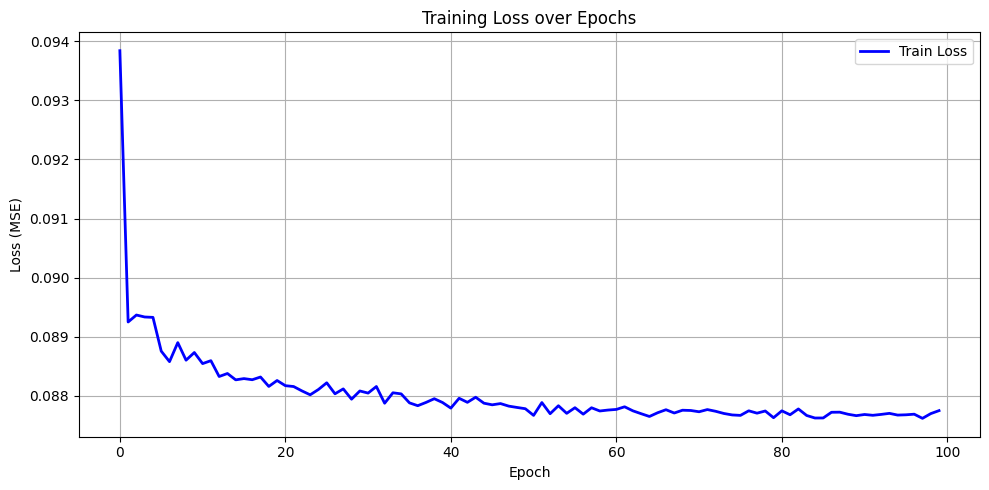

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_loss(train_losses)


Evaluate

In [ ]:
evaluate(model, test_loader)

Test Loss: 0.058401


0.05840050883630376